In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
from scipy.stats import f_oneway
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from dtw import accelerated_dtw

from bin import utils

In [2]:
fdata = sc.read_h5ad("./RNA/Multitime.clustered.h5")
gdata = sc.read_h5ad("./RNA/Multitime.filtered.guide.bin100.h5")

In [3]:
def align_rna_guide_data(fdata, gdata):
    gdata.obs.marker = gdata.obs.marker.map({
        'B926-1': '2-1',
        'B926-2': '2-2',
        'B924-1': '1-1',
        'B924-2': '1-2',
        'B922-1': '3-1',
        'B922-2': '3-2'
    })
    fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
    fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
    gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]
    fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]

    common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
    fdata = fdata[common_bins].copy()
    gdata = gdata[common_bins].copy()

    gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
    return fdata, gdata

In [4]:
fdata, gdata = align_rna_guide_data(fdata, gdata)

In [7]:
gdata

AnnData object with n_obs × n_vars = 118279 × 67
    obs: 'marker', 'cov'
    obsm: 'spatial'

In [8]:
fdata, gdata = utils.align_rna_guide_data(fdata, gdata)

In [7]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [11]:
gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()

In [10]:
c_df = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names), gdata.obs.cluster], axis=1)

In [15]:
for guide in gdata.var_names:
    if guide == "sgNTC": continue
    g_df = c_df[[guide, "sgNTC", "cluster"]]
    print(g_df)
    break

                 sgAdrb2  sgNTC  cluster
cov                                     
1-1_10049-10049        0      0        0
1-1_10049-10149        0      0        0
1-1_10049-10249        0      1        0
1-1_10049-10349        0      0       11
1-1_10049-10449        0      0        4
...                  ...    ...      ...
3-2_9949-9549          0      0       11
3-2_9949-9649          0      0       11
3-2_9949-9749          0      1        3
3-2_9949-9849          0      5        3
3-2_9949-9948          0      0        3

[118279 rows x 3 columns]


In [62]:
data = {}
for cluster in g_df.cluster.unique():
    data['guide_' + str(cluster)] = g_df.loc[g_df.cluster == cluster, guide].tolist()
    data['control_' + str(cluster)] = g_df.loc[g_df.cluster == cluster, "sgNon-targeting"].tolist()

In [67]:
sample_ids = list(data.keys())

In [70]:
dist_matrix = np.zeros((len(sample_ids), len(sample_ids)))
for i in tqdm(range(len(sample_ids))):
    for j in range(len(sample_ids)):
        seq1 = np.array(data[sample_ids[i]])
        seq2 = np.array(data[sample_ids[j]])
        dist, _, _, _ = accelerated_dtw(seq1, seq2, dist='euclidean')
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist

100%|██████████| 22/22 [10:53<00:00, 29.70s/it]


In [86]:
dm = DistanceMatrix(dist_matrix, ids=sample_ids)
metadata = pd.DataFrame({
    'group': pd.DataFrame(sample_ids)[0].str.split('_').str.get(0).tolist()
}, index=sample_ids)
results = permanova(dm, metadata, column='group')
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      22
number of groups                  2
test statistic             3.345471
p-value                       0.042
number of permutations          999
Name: PERMANOVA results, dtype: object


# Quantile based permutation

In [16]:
# The idea is to extract quantile bins in each cluster for the distribution of guide counts

# We want quantile frequency distribution to normalize the differential distribution of counts between guide and non-targeting control in linear space.
# Divide into quantile bins
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + [[np.quantile(g_df.loc[g_df.cluster == c, "sgNon-targeting"], qt) for qt in quantiles] for c in g_df.cluster.unique()])

KeyboardInterrupt: 

In [130]:
sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

In [136]:
dist_matrix = squareform(pdist(data, metric='euclidean'))

In [139]:
metadata = pd.DataFrame({
    'group': ['A'] * 11 + ['B'] * 11
}, index=sample_ids)
dm = DistanceMatrix(dist_matrix, ids=sample_ids)
results = permanova(dm, metadata, column='group')

In [19]:
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
for guide in tqdm(gdata.var_names):
    if guide == "sgNTC": continue
    g_df = c_df[[guide, "sgNTC", "cluster"]]

    data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + \
    [[np.quantile(g_df.loc[g_df.cluster == c, "sgNTC"], qt) for qt in quantiles] for c in g_df.cluster.unique()])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
    'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group')
    print(guide, results['p-value'])

  0%|          | 0/34 [00:00<?, ?it/s]

  3%|▎         | 1/34 [00:33<18:27, 33.56s/it]

sgAdrb2 0.115


  6%|▌         | 2/34 [01:06<17:48, 33.39s/it]

sgAqp3 0.038


  9%|▉         | 3/34 [01:40<17:18, 33.49s/it]

sgArntl 0.065


 12%|█▏        | 4/34 [02:15<17:09, 34.30s/it]

sgCd44 0.059


 15%|█▍        | 5/34 [02:49<16:30, 34.14s/it]

sgCd52 0.115


 18%|█▊        | 6/34 [03:23<15:53, 34.05s/it]

sgCxcl16 0.219


 21%|██        | 7/34 [04:00<15:39, 34.79s/it]

sgDdit3 0.803


 24%|██▎       | 8/34 [04:35<15:13, 35.14s/it]

sgErgic2 0.004


 26%|██▋       | 9/34 [05:23<16:18, 39.14s/it]

sgFbxo7 0.027


 29%|██▉       | 10/34 [05:57<14:56, 37.36s/it]

sgFlot1 0.071


 32%|███▏      | 11/34 [06:30<13:52, 36.19s/it]

sgGata3 0.387


 35%|███▌      | 12/34 [07:04<13:02, 35.56s/it]

sgGlb1l2 0.008


 38%|███▊      | 13/34 [07:43<12:45, 36.45s/it]

sgGpa33 0.28


 41%|████      | 14/34 [08:20<12:15, 36.78s/it]

sgIkbip 0.002


 44%|████▍     | 15/34 [09:30<14:47, 46.72s/it]

sgKcna3 0.073


 47%|████▋     | 16/34 [10:09<13:20, 44.47s/it]

sgKlrd1 0.13


 50%|█████     | 17/34 [10:46<11:55, 42.06s/it]

sgL3mbtl3 0.085


 53%|█████▎    | 18/34 [11:55<13:21, 50.08s/it]

sgMark3 0.099


 56%|█████▌    | 19/34 [12:56<13:22, 53.48s/it]

sgMcoln1 0.012


 62%|██████▏   | 21/34 [13:32<08:02, 37.08s/it]

sgNmb 0.05


 65%|██████▍   | 22/34 [14:08<07:20, 36.72s/it]

sgPiezo1 0.027


 68%|██████▊   | 23/34 [14:42<06:36, 36.01s/it]

sgPomt1 0.002


 71%|███████   | 24/34 [15:17<05:58, 35.85s/it]

sgPpia 0.177


 74%|███████▎  | 25/34 [15:52<05:21, 35.74s/it]

sgS100a11 0.159


 76%|███████▋  | 26/34 [16:26<04:41, 35.21s/it]

sgScamp4 0.345


 79%|███████▉  | 27/34 [17:03<04:09, 35.61s/it]

sgSlc39a8 0.018


 82%|████████▏ | 28/34 [17:42<03:39, 36.55s/it]

sgSorl1 0.025


 85%|████████▌ | 29/34 [18:21<03:06, 37.37s/it]

sgSrgn 0.004


 88%|████████▊ | 30/34 [19:06<02:38, 39.56s/it]

sgTmem64 0.627


 91%|█████████ | 31/34 [19:43<01:56, 38.92s/it]

sgWipf1 0.127


 94%|█████████▍| 32/34 [20:20<01:16, 38.24s/it]

sgZc3h12a 0.462


 97%|█████████▋| 33/34 [20:58<00:38, 38.33s/it]

sgZhx2 0.484


100%|██████████| 34/34 [21:34<00:00, 38.08s/it]

sgZscan12 0.163


In [150]:
g_df.groupby('cluster').apply(lambda x: [g_df[s] for s in x])

/tmp/ipykernel_78447/1473318181.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df.groupby('cluster').apply(lambda x: [g_df[s] for s in x])


cluster
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
5     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
6     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
7     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
8     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
9     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
10    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
dtype: object

In [11]:
def calculate_quantiles(group, quantiles):
    return [np.quantile(group, qt) for qt in quantiles]

In [ ]:
c_df.groupby('groupby')

In [21]:
non_targeting_quantiles[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
n_quantiles = 1000
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)
p_value = {}
f_value = {}
for guide in tqdm(gdata.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    #data = np.array([[np.quantile(g_df.loc[g_df.cluster == c, guide], qt) for qt in quantiles] for c in g_df.cluster.unique()] + \
    #[[np.quantile(g_df.loc[g_df.cluster == c, "sgNon-targeting"], qt) for qt in quantiles] for c in g_df.cluster.unique()])
    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    guide_quantiles = np.array(g_df.groupby('cluster')[guide].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
    non_targeting_quantiles = np.array(g_df.groupby('cluster')['sgnon-targeting'].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
    data = np.vstack([guide_quantiles, non_targeting_quantiles])[:, -100:]
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

100%|██████████| 34/34 [05:42<00:00, 10.09s/it]


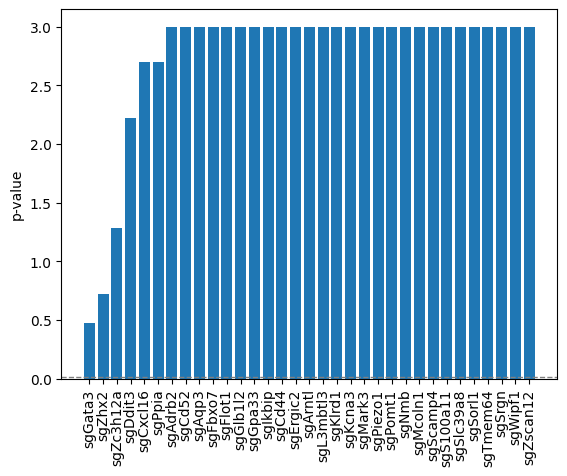

In [16]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
plt.bar(p_df.index, -np.log10(p_df[0]))
plt.axhline(y=0.01, color='gray', linewidth=1, linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [36]:
df = pd.DataFrame(index=range(10))
pd.concat([g_df.groupby('sgZscan12').count(), df], axis=1).fillna(0)['cluster'].tolist()

[114981.0, 3042.0, 250.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [52]:
g_df.groupby(['cluster', guide]).count().unstack()['sgZscan12']

sgnon-targeting,0,1,2,3,4,5
cluster,,,,,,
0,9024.0,724.0,84.0,7.0,1.0,NaN
1,14135.0,1768.0,262.0,29.0,3.0,NaN
2,12372.0,612.0,45.0,NaN,NaN,NaN
3,9315.0,2384.0,561.0,122.0,11.0,1.0
4,7315.0,724.0,114.0,10.0,1.0,NaN
5,8195.0,361.0,24.0,2.0,NaN,NaN
6,4980.0,297.0,32.0,1.0,NaN,1.0
7,8408.0,867.0,162.0,25.0,4.0,NaN
8,5900.0,253.0,15.0,2.0,NaN,NaN


In [54]:
df = pd.DataFrame(columns=range(10))
np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgZscan12']], axis=0).fillna(0))

/tmp/ipykernel_46566/3305448557.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgZscan12']], axis=0).fillna(0))
/tmp/ipykernel_46566/3305448557.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgZscan12']], axis=0).fillna(0))


array([[9.0240e+03, 7.2400e+02, 8.4000e+01, 7.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.4135e+04, 1.7680e+03, 2.6200e+02, 2.9000e+01, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.2372e+04, 6.1200e+02, 4.5000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [9.3150e+03, 2.3840e+03, 5.6100e+02, 1.2200e+02, 1.1000e+01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [7.3150e+03, 7.2400e+02, 1.1400e+02, 1.0000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [8.1950e+03, 3.6100e+02, 2.4000e+01, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [4.9800e+03, 2.9700e+02, 3.2000e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [8.4080e+03, 8.6700e+02, 1.6200e+0

In [65]:
pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=1)

,0,1,2,3,4
0,9586.0,238.0,16.0,NaN,NaN
1,15465.0,688.0,42.0,2.0,NaN
2,12822.0,202.0,4.0,1.0,NaN
3,11422.0,900.0,71.0,1.0,NaN
4,7842.0,296.0,23.0,3.0,NaN
5,8449.0,128.0,5.0,NaN,NaN
6,5240.0,70.0,1.0,NaN,NaN
7,9062.0,365.0,35.0,3.0,1.0
8,6094.0,75.0,1.0,NaN,NaN
9,5298.0,81.0,2.0,NaN,NaN


In [69]:
p_value = {}
f_value = {}
for guide in tqdm(gdata.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/2976965577.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
/tmp/ipykernel_46566/2976965577.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
/tmp/ipykernel_46566/2976965577.py:11: FutureWarning: The behavior

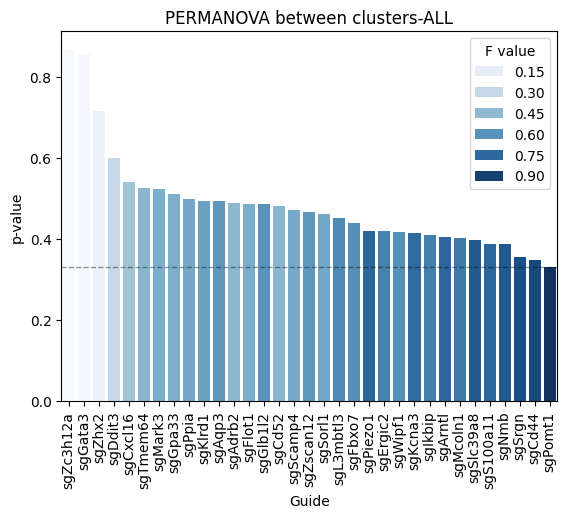

In [95]:
import seaborn as sns

p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters-ALL')
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

  0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_46566/399767498.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/399767498.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/399767498.py:14: FutureWarning: The behavior of DataFrame concate

AttributeError: 'str' object has no attribute 'items'

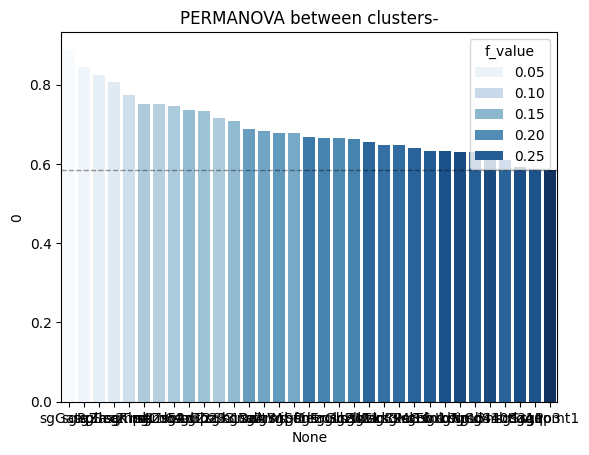

In [98]:
p_value = {}
f_value = {}
marker = '1-1'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

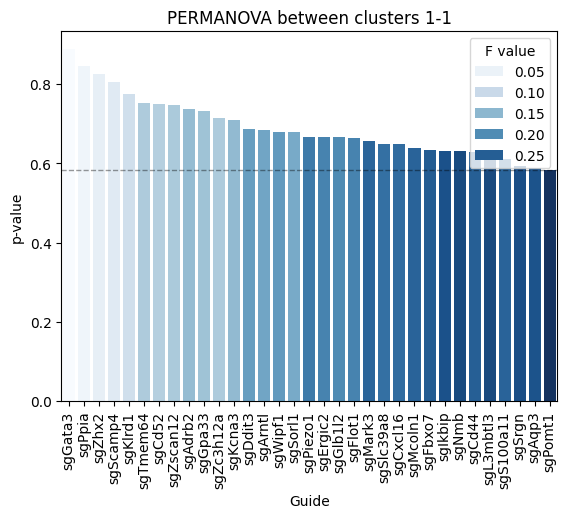

In [100]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [101]:
p_value = {}
f_value = {}
marker = '1-2'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/1226577127.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1226577127.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1226577127.py:14: FutureW

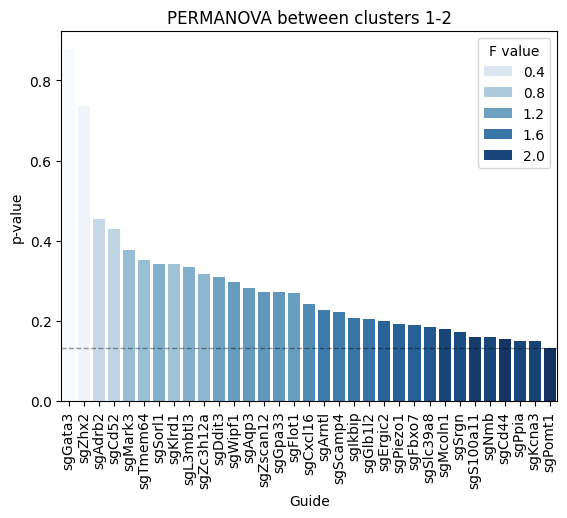

In [102]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [103]:
p_value = {}
f_value = {}
marker = '2-1'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/2861453088.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/2861453088.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/2861453088.py:14: FutureW

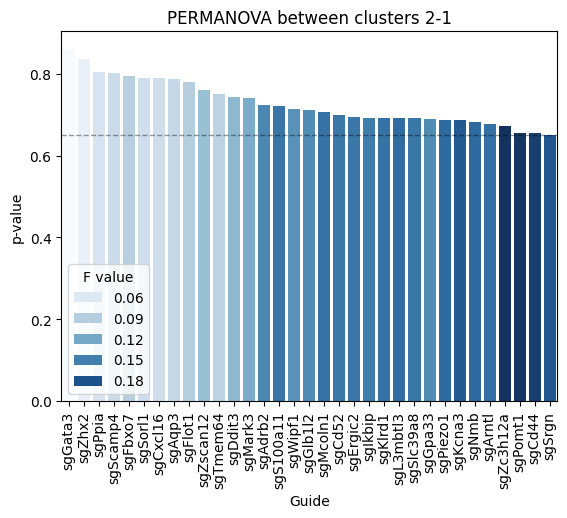

In [104]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [105]:
p_value = {}
f_value = {}
marker = '2-2'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/1976373972.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1976373972.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1976373972.py:14: FutureW

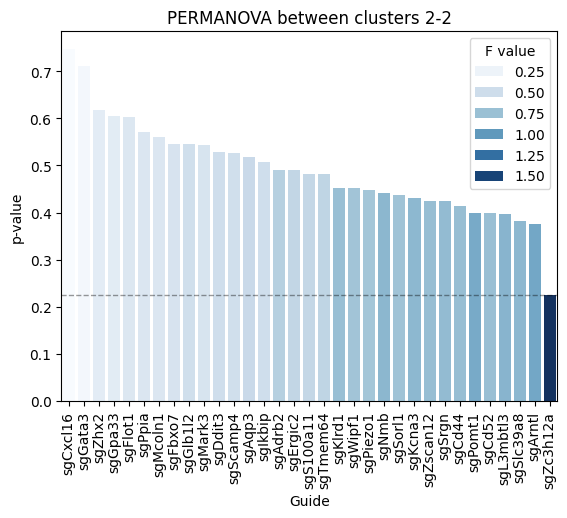

In [106]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [107]:
p_value = {}
f_value = {}
marker = '3-1'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/1828019527.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1828019527.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/1828019527.py:14: FutureW

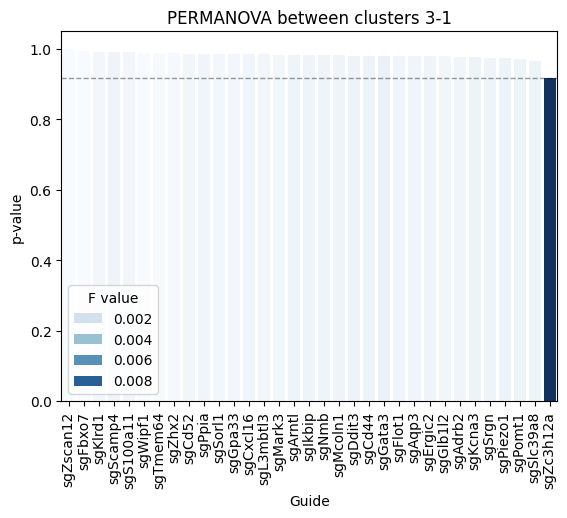

In [108]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [109]:
p_value = {}
f_value = {}
marker = '3-2'
gdata_ = gdata[gdata.obs.marker == marker]
c_df = pd.concat([pd.DataFrame(gdata_.X, columns=gdata_.var_names, index=gdata_.obs_names), gdata_.obs.cluster], axis=1)
for guide in tqdm(gdata_.var_names):
    if guide == "sgnon-targeting": continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(10))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide].fillna(0)], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='euclidean'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    #print(guide, results['p-value'])
    p_value[guide] = results['p-value']
    f_value[guide] = results['test statistic']

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_46566/703537356.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/703537356.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting'].fillna(0)], axis=0).fillna(0))
/tmp/ipykernel_46566/703537356.py:14: FutureWarn

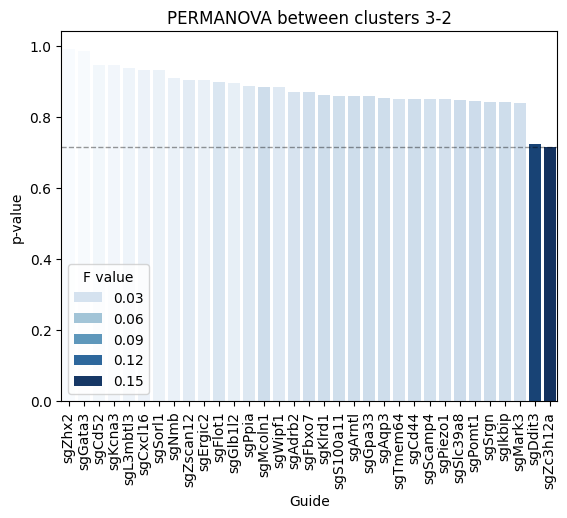

In [110]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys()).sort_values(by=0, ascending=False)
p_df['f_value'] = pd.DataFrame(f_value, index=['f_value']).T.loc[p_df.index]['f_value'].tolist()
sns.barplot(p_df, x=p_df.index, y=0, hue='f_value', palette='Blues', legend=True)
plt.axhline(y=p_df[0].min(), color='black', linewidth=1, linestyle='--', alpha=0.4)
plt.title('PERMANOVA between clusters ' + marker)
plt.xlabel('Guide')
plt.legend(title='F value')
plt.xticks(rotation=90)
plt.ylabel('p-value')
plt.show()

In [112]:
gdata_[:, 'sgZc3h12a'].X.sum()

array(2911)